<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implement a scoring model - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Preprocessing Notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1 Libraries</h3>
</div>

In [1]:
import gc
import time
import re
from contextlib import contextmanager
import numpy as np
import pandas as pd

from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">Timer</h3>
</div>

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">Categorical encoder</h3>
</div>

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">Preprocess main table</h3>
</div>

In [64]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    
    # Read data and merge
    df = pd.read_csv(r"app_train.csv", nrows=num_rows)
    #test_df = pd.read_csv(r"app_test.csv", nrows=num_rows)
    #print("Train samples: {}".format(len(df))#, len(test_df)))
    #df = df.append(test_df).reset_index()
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    #del test_df
    gc.collect()
    
    return df

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">Bureau and Bureau balance</h3>
</div>

In [5]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    
    # Read data
    bureau = pd.read_csv(r"app_bureau.csv", nrows=num_rows)
    bb = pd.read_csv(r"app_bureau_balance.csv", nrows=num_rows)
    
    # Categorical features with One-Hot encode
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">Previous applications</h3>
</div>

In [6]:
# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    
    # Read data
    prev = pd.read_csv(r"app_previous_application.csv", nrows=num_rows)
    
    # Categorical features with One-Hot encode
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">Pos Cash
</div>

In [7]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    
    # Read data
    pos = pd.read_csv(r"app_POS_CASh.csv", nrows=num_rows)
    
    # Categorical features with One-Hot encode
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos
    gc.collect()
    
    return pos_agg

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">Installments payments</h3>
</div>

In [8]:
# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    
    # Read data
    ins = pd.read_csv(r"app_installments.csv", nrows=num_rows)
    
    # Categorical features with One-Hot encode
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    for cat in cat_cols:
        aggregations[cat] = ['mean']
        
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    del ins
    gc.collect()
    
    return ins_agg

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">Credit Card Balance</h3>
</div>

In [9]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    
    # Read data
    cc = pd.read_csv(r"app_credit.csv", nrows=num_rows)
    
    # Categorical features with One-Hot encode
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
    
    return cc_agg

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">LightGBM GBDT with KFold or Stratified KFold<br>
</h3>
</div>
Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

In [93]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= True):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        #sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [89]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Main function</h2>
</div>

In [12]:
def main(debug=False):      
    # To test with less data
    num_rows = 10000 if debug else None    
    with timer("Process Train/Test df"):    
        df = application_train_test(num_rows)
        print("\n")
        print(">> application_train_test")
        print("Train/Test df shape:", df.shape)
        #display(df.head())
    
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("\n")
        print(">> bureau_and_balance")
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
        #display(df.head())
        
        
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("\n")
        print(">> previous_applications")
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
        #display(df.head())

        
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("\n")
        print(">> pos_cash")
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
        #display(df.head())
        

    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("\n")
        print(">> installments_payments")
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
        #display(df.head())
        
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("\n")
        print(">> credit_card_balance")
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

   # with timer("Run LightGBM with kfold"):
   #     feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
     
        
    return df
    #return df, feat_importance


In [13]:
def ana_missing_data(df):    
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data=missing_data[missing_data["Total"]>0].head(10)
    return missing_data

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Results du préprocessing </h2>
</div>

In [65]:
with timer("\n\nFull model run"):
    df = main()
    #df, feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)



>> application_train_test
Train/Test df shape: (307507, 247)
Process Train/Test df - done in 5s


>> bureau_and_balance
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s


>> previous_applications
Previous applications df shape: (338857, 249)
Process previous_applications - done in 27s


>> pos_cash
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 13s


>> installments_payments
Installments payments df shape: (339587, 26)
Process installments payments - done in 24s


>> credit_card_balance
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 18s


Full model run - done in 106s


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6 Optimizing memory usage</h2>
</div>

<div class="alert alert-block alert-warning">
    <p>We should optimize the memory usage to avoid problems during executions</p>
</div>

In [66]:
df.shape

(307507, 797)

In [67]:
ana_missing_data(df)

,Total,Percent
REFUSED_APP_CREDIT_PERC_VAR,258350,84.014348
ACTIVE_MONTHS_BALANCE_SIZE_MEAN,230988,75.116339
ACTIVE_MONTHS_BALANCE_MAX_MAX,230988,75.116339
ACTIVE_MONTHS_BALANCE_MIN_MIN,230988,75.116339
CLOSED_MONTHS_BALANCE_MIN_MIN,226772,73.745313
CLOSED_MONTHS_BALANCE_MAX_MAX,226772,73.745313
CLOSED_MONTHS_BALANCE_SIZE_MEAN,226772,73.745313
CC_AMT_DRAWINGS_CURRENT_VAR,221234,71.944379
CC_NAME_CONTRACT_STATUS_Active_VAR,221234,71.944379
CC_NAME_CONTRACT_STATUS_Completed_VAR,221234,71.944379


In [68]:
df["TARGET"].fillna(value=-99, inplace=True)
df["TARGET"] = df["TARGET"].astype("int8")
df["TARGET"] = df["TARGET"].replace(-99, np.nan)

In [69]:
def memory_optimization(df):
    """
    Method used to optimize the memory usage.
    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        
    Returns:
    -----------------
        df (pandas.DataFrame): Dataset optimized
    """ 
    
    for col in df.columns:
        if df[col].dtype == "int64" and df[col].nunique() == 2:
            df[col] = df[col].astype("int8")
            
    for col in df.columns:
        if df[col].dtype == "float64" and df[col].min() >= -2147483648 and df[col].max() <= 2147483648:
            df[col] = df[col].astype("float32")
            
    return df

Starting LightGBM. Train shape: (307507, 608), test shape: (0, 608)


/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.793032	training's binary_logloss: 0.236224	valid_1's auc: 0.774051	valid_1's binary_logloss: 0.24764
[400]	training's auc: 0.81542	training's binary_logloss: 0.226952	valid_1's auc: 0.785132	valid_1's binary_logloss: 0.243515
[600]	training's auc: 0.830279	training's binary_logloss: 0.221045	valid_1's auc: 0.789736	valid_1's binary_logloss: 0.241896
[800]	training's auc: 0.842818	training's binary_logloss: 0.216022	valid_1's auc: 0.791842	valid_1's binary_logloss: 0.241144
[1000]	training's auc: 0.853661	training's binary_logloss: 0.211611	valid_1's auc: 0.792894	valid_1's binary_logloss: 0.240728
[1200]	training's auc: 0.86339	training's binary_logloss: 0.207524	valid_1's auc: 0.793501	valid_1's binary_logloss: 0.24052
[1400]	training's auc: 0.872006	training's binary_logloss: 0.203751	valid_1's auc: 0.793672	valid_1's binary_logloss: 0.240476


/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.793077	training's binary_logloss: 0.236861	valid_1's auc: 0.774321	valid_1's binary_logloss: 0.242567
[400]	training's auc: 0.815768	training's binary_logloss: 0.227548	valid_1's auc: 0.783969	valid_1's binary_logloss: 0.238273
[600]	training's auc: 0.830527	training's binary_logloss: 0.221604	valid_1's auc: 0.786939	valid_1's binary_logloss: 0.237022
[800]	training's auc: 0.842844	training's binary_logloss: 0.216713	valid_1's auc: 0.788803	valid_1's binary_logloss: 0.236393
[1000]	training's auc: 0.85348	training's binary_logloss: 0.2124	valid_1's auc: 0.789767	valid_1's binary_logloss: 0.236064
[1200]	training's auc: 0.863045	training's binary_logloss: 0.208448	valid_1's auc: 0.790239	valid_1's binary_logloss: 0.235903
[1400]	training's auc: 0.871668	training's binary_logloss: 0.204669	valid_1's auc: 0.790404	valid_1's binary_logloss: 0.23583


/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.793739	training's binary_logloss: 0.236313	valid_1's auc: 0.765179	valid_1's binary_logloss: 0.247427
[400]	training's auc: 0.816331	training's binary_logloss: 0.227063	valid_1's auc: 0.775975	valid_1's binary_logloss: 0.24344
[600]	training's auc: 0.831417	training's binary_logloss: 0.220961	valid_1's auc: 0.779498	valid_1's binary_logloss: 0.242212
[800]	training's auc: 0.843317	training's binary_logloss: 0.216178	valid_1's auc: 0.781701	valid_1's binary_logloss: 0.24154
[1000]	training's auc: 0.853368	training's binary_logloss: 0.212037	valid_1's auc: 0.782582	valid_1's binary_logloss: 0.241261
[1200]	training's auc: 0.863093	training's binary_logloss: 0.207976	valid_1's auc: 0.783174	valid_1's binary_logloss: 0.241051
[1400]	training's auc: 0.871962	training's binary_logloss: 0.204133	valid_1's auc: 0.783403	valid_1's binary_logloss: 0.24095

/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.792835	training's binary_logloss: 0.23696	valid_1's auc: 0.775783	valid_1's binary_logloss: 0.241967
[400]	training's auc: 0.815521	training's binary_logloss: 0.227602	valid_1's auc: 0.78623	valid_1's binary_logloss: 0.237627
[600]	training's auc: 0.830348	training's binary_logloss: 0.221679	valid_1's auc: 0.78981	valid_1's binary_logloss: 0.236236
[800]	training's auc: 0.842277	training's binary_logloss: 0.216908	valid_1's auc: 0.791424	valid_1's binary_logloss: 0.235578
[1000]	training's auc: 0.85274	training's binary_logloss: 0.212597	valid_1's auc: 0.792233	valid_1's binary_logloss: 0.235273
[1200]	training's auc: 0.862499	training's binary_logloss: 0.208522	valid_1's auc: 0.792773	valid_1's binary_logloss: 0.235046
[1400]	training's auc: 0.871417	training's binary_logloss: 0.204613	valid_1's auc: 0.792909	valid_1's binary_logloss: 0.234937


/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.792725	training's binary_logloss: 0.237614	valid_1's auc: 0.776459	valid_1's binary_logloss: 0.235079
[400]	training's auc: 0.815273	training's binary_logloss: 0.228307	valid_1's auc: 0.787001	valid_1's binary_logloss: 0.230816
[600]	training's auc: 0.83029	training's binary_logloss: 0.222314	valid_1's auc: 0.790769	valid_1's binary_logloss: 0.229413
[800]	training's auc: 0.842138	training's binary_logloss: 0.217538	valid_1's auc: 0.792356	valid_1's binary_logloss: 0.228798
[1000]	training's auc: 0.852475	training's binary_logloss: 0.213281	valid_1's auc: 0.793592	valid_1's binary_logloss: 0.228395
[1200]	training's auc: 0.861947	training's binary_logloss: 0.209295	valid_1's auc: 0.794002	valid_1's binary_logloss: 0.228199
[1400]	training's auc: 0.870773	training's binary_logloss: 0.205462	valid_1's auc: 0.794523	valid_1's binary_logloss: 0.2279

/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.793574	training's binary_logloss: 0.236673	valid_1's auc: 0.764221	valid_1's binary_logloss: 0.24408
[400]	training's auc: 0.816062	training's binary_logloss: 0.227395	valid_1's auc: 0.775766	valid_1's binary_logloss: 0.240087
[600]	training's auc: 0.830726	training's binary_logloss: 0.22159	valid_1's auc: 0.779914	valid_1's binary_logloss: 0.238719
[800]	training's auc: 0.843054	training's binary_logloss: 0.216711	valid_1's auc: 0.781926	valid_1's binary_logloss: 0.238024
[1000]	training's auc: 0.853576	training's binary_logloss: 0.212428	valid_1's auc: 0.782884	valid_1's binary_logloss: 0.237632
[1200]	training's auc: 0.863231	training's binary_logloss: 0.208348	valid_1's auc: 0.783352	valid_1's binary_logloss: 0.237485
[1400]	training's auc: 0.872213	training's binary_logloss: 0.204437	valid_1's auc: 0.783394	valid_1's binary_logloss: 0.23748

/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.793287	training's binary_logloss: 0.236954	valid_1's auc: 0.772612	valid_1's binary_logloss: 0.241445
[400]	training's auc: 0.815852	training's binary_logloss: 0.227655	valid_1's auc: 0.782836	valid_1's binary_logloss: 0.237243
[600]	training's auc: 0.831316	training's binary_logloss: 0.221479	valid_1's auc: 0.786747	valid_1's binary_logloss: 0.235734
[800]	training's auc: 0.84358	training's binary_logloss: 0.216572	valid_1's auc: 0.787985	valid_1's binary_logloss: 0.235261
[1000]	training's auc: 0.853883	training's binary_logloss: 0.212381	valid_1's auc: 0.788539	valid_1's binary_logloss: 0.235077
[1200]	training's auc: 0.863643	training's binary_logloss: 0.208272	valid_1's auc: 0.788742	valid_1's binary_logloss: 0.234952
[1400]	training's auc: 0.872691	training's binary_logloss: 0.204304	valid_1's auc: 0.788892	valid_1's binary_logloss: 0.2349

/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.793407	training's binary_logloss: 0.236469	valid_1's auc: 0.768096	valid_1's binary_logloss: 0.246063
[400]	training's auc: 0.815878	training's binary_logloss: 0.227195	valid_1's auc: 0.779473	valid_1's binary_logloss: 0.241747
[600]	training's auc: 0.830771	training's binary_logloss: 0.221264	valid_1's auc: 0.784107	valid_1's binary_logloss: 0.240108
[800]	training's auc: 0.842929	training's binary_logloss: 0.216436	valid_1's auc: 0.786141	valid_1's binary_logloss: 0.239423
[1000]	training's auc: 0.853375	training's binary_logloss: 0.21216	valid_1's auc: 0.787262	valid_1's binary_logloss: 0.239077
[1200]	training's auc: 0.862948	training's binary_logloss: 0.208128	valid_1's auc: 0.787826	valid_1's binary_logloss: 0.238929
[1400]	training's auc: 0.87158	training's binary_logloss: 0.204363	valid_1's auc: 0.788001	valid_1's binary_logloss: 0.23883

/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.792839	training's binary_logloss: 0.236677	valid_1's auc: 0.777886	valid_1's binary_logloss: 0.243346
[400]	training's auc: 0.815392	training's binary_logloss: 0.227419	valid_1's auc: 0.78854	valid_1's binary_logloss: 0.239001
[600]	training's auc: 0.830239	training's binary_logloss: 0.221463	valid_1's auc: 0.79262	valid_1's binary_logloss: 0.237421
[800]	training's auc: 0.842481	training's binary_logloss: 0.21661	valid_1's auc: 0.794407	valid_1's binary_logloss: 0.236631
[1000]	training's auc: 0.853164	training's binary_logloss: 0.212257	valid_1's auc: 0.795345	valid_1's binary_logloss: 0.236228
[1200]	training's auc: 0.863019	training's binary_logloss: 0.20819	valid_1's auc: 0.795844	valid_1's binary_logloss: 0.23602
[1400]	training's auc: 0.872123	training's binary_logloss: 0.204271	valid_1's auc: 0.795874	valid_1's binary_logloss: 0.235994
F

/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bdiallo/miniconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depreca

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.793408	training's binary_logloss: 0.236892	valid_1's auc: 0.769268	valid_1's binary_logloss: 0.241673
[400]	training's auc: 0.815737	training's binary_logloss: 0.227707	valid_1's auc: 0.78003	valid_1's binary_logloss: 0.237606
[600]	training's auc: 0.830633	training's binary_logloss: 0.221734	valid_1's auc: 0.783735	valid_1's binary_logloss: 0.236175
[800]	training's auc: 0.842802	training's binary_logloss: 0.216872	valid_1's auc: 0.785633	valid_1's binary_logloss: 0.235546
[1000]	training's auc: 0.853378	training's binary_logloss: 0.212561	valid_1's auc: 0.786924	valid_1's binary_logloss: 0.235115
[1200]	training's auc: 0.86309	training's binary_logloss: 0.208454	valid_1's auc: 0.787466	valid_1's binary_logloss: 0.234943
[1400]	training's auc: 0.871922	training's binary_logloss: 0.204632	valid_1's auc: 0.787924	valid_1's binary_logloss: 0.23479

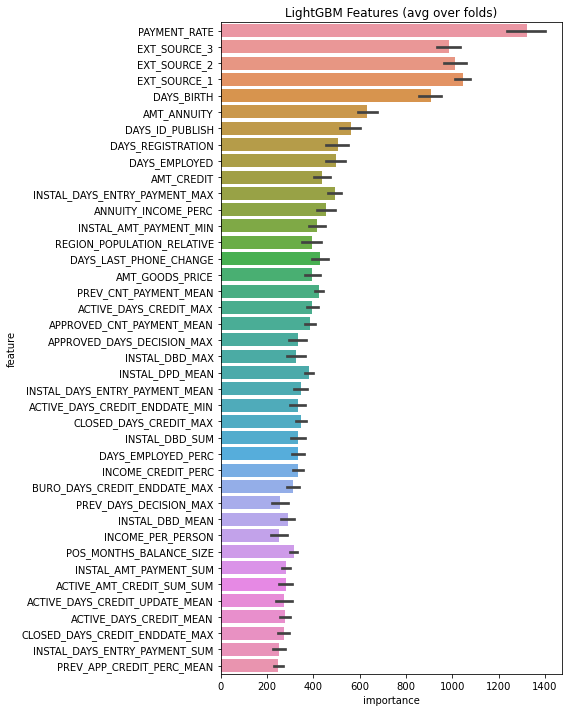

In [94]:
feat_importance = kfold_lightgbm(df_essai, num_folds= 10)

In [70]:
df = memory_optimization(df)

<div class="alert alert-block alert-success">
    <p>We can see how the memory used has been reduced</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">7. Missing-values</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to treat the missing-values in all the dataset, to do that, we are going to do the following steps</p>
    <ol>
        <li><b>suppression des columns de plus de 60% de Missing values</b></li>
        <li><b>Remplace of infinite-values with NaN</b></li>
        <li><b>rFill missing-values with SimpleImputer</b> - There are 25 infinite values</li>
    </ol> 
    <p>Let's start by identifying the features with infinite-values and replace them by missing-values
   </p>
</div>
</div>

In [99]:
inf_cols = df.columns.to_series()[np.isinf(df).any()]

In [100]:
inf_cols

Series([], dtype: object)

In [98]:
for col in inf_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)

<div class="alert alert-block alert-info">
    <p>Now, we are going to delete all columns with 20% or plus of missing-values. But first, we have to save the TARGET variable
   </p>
</div>
</div>

In [74]:
#df_essai = df.dropna(thresh=0.8*len(df), axis=1)

In [101]:
df_essai = df.loc[:, df.isnull().mean() < .6]
df_essai.shape

(307507, 608)

In [78]:
# Deleting the dataset temporal
del df_temp
gc.collect()

0

In [104]:
nan_cols = [i for i in df_essai.columns if i!="TARGET" and df_essai[i].isnull().any()]

In [80]:
for col in nan_cols:
    mean_value = df_essai[col].mean()
    df_essai[col].fillna(value=mean_value, inplace=True)

/home/bdiallo/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [81]:
df_essai.info(), df_essai.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 608 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: float32(465), float64(6), int8(4), uint8(133)
memory usage: 602.1 MB


(None, (307507, 608))

<div class="alert alert-block alert-success">
    <p>Now, we only have missing values on the Target
   </p>
</div>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">8. Saving datasets</h2>
</div>

<div class="alert alert-block alert-info">
    <p>At this point, we are going to save current clients separate from clients to predict.</p>
    <p>But, before that, we are going to format columns name in the dataset</p>
</div>

In [82]:
# Formatting columns name (suppression espace et suppression #lettre)
df_essai = df_essai.rename(columns=lambda x:re.sub("[^A-Za-z0-9_]+", "", x))

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.1 Current clients</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, let's save the current clients</p>
</div>
</div>

In [95]:
df_essai.shape

(307507, 608)

In [84]:
df_current_clients = df_essai[df_essai["TARGET"].notnull()]
df_current_clients.shape

(307507, 608)

In [ ]:
## traint_split à  faire

In [53]:
# saving the current clients
df_current_clients.to_csv("df_current_clients.csv", encoding='utf-8', index=False)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.2 Clients to predict</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's start saving the customers that we are going to predict</p>
</div>
</div>

In [85]:
df_clients_to_predict = df_essai[df_essai["TARGET"].isnull()]

In [56]:
# dropping TARGET feature
df_clients_to_predict = df_clients_to_predict.drop(columns=["TARGET"])

In [58]:
# saving the clients to predict
df_clients_to_predict.to_csv("df_clients_to_predict.csv", index=False)
df.to_csv("df.csv", index=False)

In [60]:
df_clients_to_predict.shape

(48744, 608)

In [37]:
del df_clients_to_predict, df
gc.collect()

0